# 3. Topic Modeling

In [1]:
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
import gensim
from gensim import corpora
import nltk

# Load and preprocess the dataset
df = pd.read_csv('data/joined_review.csv').head(100000)

/usr/local/lib/python3.10/dist-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

def clean(doc):
    stop = set(stopwords.words('english'))
    exclude = set(string.punctuation) 
    lemma = WordNetLemmatizer()
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc_clean = [clean(doc).split() for doc in df['text']]


[nltk_data] Downloading package stopwords to /home/nemin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/nemin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Creating the term dictionary of our corpus, where every unique term is assigned an index
dictionary = corpora.Dictionary(doc_clean)

# Converting list of documents (corpus) into Document Term Matrix using the dictionary
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

In [4]:
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
limit=25; start=6; step=3;

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, random_state=100, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Can take a long time to run
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=doc_clean, start=start, limit=limit, step=step)

6
9
12
15
18
21
24


/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


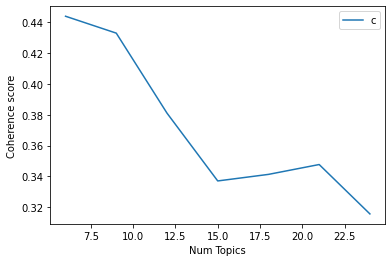

Num Topics = 6  has Coherence Value of 0.4439
Num Topics = 9  has Coherence Value of 0.433
Num Topics = 12  has Coherence Value of 0.381
Num Topics = 15  has Coherence Value of 0.337
Num Topics = 18  has Coherence Value of 0.3412
Num Topics = 21  has Coherence Value of 0.3476
Num Topics = 24  has Coherence Value of 0.3156


In [5]:
# Show graph
import matplotlib.pyplot as plt

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))


In [6]:
# Select the model and print the topics
optimal_model = model_list[coherence_values.index(max(coherence_values))]
# optimal_model = model_list[0]
model_topics = optimal_model.show_topics(formatted=False)


In [7]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(optimal_model, doc_term_matrix, dictionary)
vis


/usr/local/lib/python3.10/dist-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.240266  0.004935       1        1  34.256317
1      0.237278  0.011232       2        1  34.102325
5      0.031589 -0.224821       3        1  13.502995
2     -0.002191  0.337038       4        1   7.936941
0     -0.163630 -0.223097       5        1   7.785969
3     -0.343311  0.094713       6        1   2.415453, topic_info=         Term          Freq         Total Category  logprob  loglift
139     place  56455.000000  56455.000000  Default  30.0000  30.0000
184     great  48085.000000  48085.000000  Default  29.0000  29.0000
14       good  51138.000000  51138.000000  Default  28.0000  28.0000
12       food  58177.000000  58177.000000  Default  27.0000  27.0000
118   chicken  12622.000000  12622.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
2823      cup   1054.800573   1823.313478   Topic6  -4.8021   3.1760
535     sweet   1244.798441   6144.039138   Topic6  -4.6364   2.1268
606    flavor   1136.658944   8237.294033   Topic6  -4.7273   1.7427
1387     shop    873.415756   4765.230400   Topic6  -4.9908   2.0266
3264    fruit    729.785448   1215.653679   Topic6  -5.1704   3.2130

[302 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1552      4  0.990129      1
1552      6  0.009577      1
146       2  0.999719     10
0         2  0.999865      2
210       2  0.999809      3
...     ...       ...    ...
108       4  0.573483   work
707       1  0.992866  worth
707       3  0.007082  worth
209       1  0.055861  would
209       2  0.944119  would

[362 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 6, 3, 1, 4])